In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"
import torch
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from torch import nn
import torch.nn.functional as F
import gin
from causal_util import load_env
from causal_util.collect_data import EnvDataCollector
from matplotlib import pyplot as plt
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.learners.rl_learner import CausalModelLearnerRL
import gin
from sparse_causal_model_learner_rl.sacred_gin_tune.sacred_wrapper import load_config_files
from sparse_causal_model_learner_rl.config.config import Config
from sparse_causal_model_learner_rl.trainable.decoder import IdentityDecoder
from keychest.keychestenv import obss_to_rgb
import tensorflow as tf
from keras_tqdm import TQDMNotebookCallback


In [2]:
%%javascript
var jq = document.createElement('script');
jq.src = "https://ajax.googleapis.com/ajax/libs/jquery/2.1.4/jquery.min.js";
document.getElementsByTagName('head')[0].appendChild(jq);

<IPython.core.display.Javascript object>

In [3]:
%load_ext jupyternotify
%autonotify -a 30

<IPython.core.display.Javascript object>

In [4]:
load_config_files(['../sparse_causal_model_learner_rl/configs/common.gin', '../keychest/config/5x5.gin'])

['common', '5x5']

In [5]:
learner = CausalModelLearnerRL(Config())
env = learner.env
h, w, c = env.engine._observation.shape

Make environment KeyChest-v0 None {}


In [6]:
def get_xy(steps=1000):
    """Get the dataset."""
    gin.bind_parameter('Config.feature_shape', None)
    gin.bind_parameter('KeyChestEnvironment.flatten_observation', True)
    gin.bind_parameter('Config.env_steps', steps)
    gin.bind_parameter('Config.decoder', None)
    gin.bind_parameter('Config.model', None)
    gin.bind_parameter('Config.reconstructor', None)
    gin.bind_parameter('Config.value_predictor', None)
    learner = CausalModelLearnerRL(Config())
    learner.collect_steps(do_tqdm=True)
    obs_x = learner._context.get('obs_x').cpu().numpy()
    obs_y = learner._context.get('obs_y').cpu().numpy()
    act_x = learner._context.get('action_x').cpu().numpy()

    X = np.concatenate((obs_x, act_x), axis=1)
    y = obs_y
    return X, y

In [463]:
X, _ = get_xy(100000)
X = X[:, :-4]
X = X.reshape((-1, h, w, c))
X_rgb = obss_to_rgb(X, env.engine)

Make environment KeyChest-v0 None {}



3.0


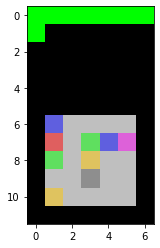

In [464]:
plt.imshow(X_rgb[0])

In [465]:
def dict_to_arr(d):
    """Dictionary to a list with keys sorted."""
    return np.array([d[k] for k in sorted(d.keys())], dtype=np.float32)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [466]:
def arr_to_dict(arr, keys):
    """Array back to dictionary."""
    assert len(arr) == len(keys)
    return {x: y for x, y in zip(sorted(keys), arr)}

In [467]:
def obs_features_handcoded(obs, env):
    """Get features for an observation."""
    engine = env.engine
    
    def get_map(key):
        idx = engine.OBJECTS.index(key)
        return obs[:, :, idx]
    
    result = {}
    result['health'] = np.sum(get_map('health'))
    result['keys'] = np.sum(get_map('keys_collected'))
    lamp_on = np.sum(get_map('lamp_on'))
    lamp_off = np.sum(get_map('lamp_off'))
    result['lamp_status'] = 1 if lamp_on else (0 if lamp_off else -1)
    
    n_keys = gin.query_parameter('KeyChestEnvironmentRandom.n_keys')
    n_chests = gin.query_parameter('KeyChestEnvironmentRandom.n_chests')
    n_food = gin.query_parameter('KeyChestEnvironmentRandom.n_food')
    
    objects_to_out = ['key', 'chest', 'food', 'button', 'player', 'lamp_on', 'lamp_off']
    objects_cnt = {'key': n_keys, 'chest': n_chests, 'food': n_food}
    
    def register(key, x, y, idx=None):
        if x is None:
            x = -1
        if y is None:
            y = -1
        name_prefix = key + "_"
        if idx is not None:
            name_prefix = "%s%02d_" % (name_prefix, idx)
        
        result[name_prefix + "x"] = x
        result[name_prefix + "y"] = y
    
    def arr_get_val(arr, idx):
        if idx < len(arr):
            x, y = arr[idx]
        else:
            x, y = -1, -1
        return x, y
    
    for key in objects_to_out:
        m = get_map(key)
        where = sorted(list(zip(*np.where(m))))
#         print(key, where)
        assert len(where) <= 1 or key in objects_cnt
        
        if key in objects_cnt:
            for i in range(objects_cnt[key]):
                x, y = arr_get_val(where, i)
                register(key, x, y, i)
        else:
            x, y = arr_get_val(where, 0)
            register(key, x, y, None)
    
    return result

In [468]:
Fdict = [obs_features_handcoded(x, env) for x in X]
F = np.array([dict_to_arr(f) for f in Fdict])

In [469]:
Fkeys = Fdict[0].keys()

In [470]:
f = obs_features_handcoded(X[0], env)

In [471]:
dict_to_arr(f)

array([ 7.,  5.,  8.,  3., 10.,  1.,  7.,  3.,  8.,  1.,  8.,  6.,  1.,
        7.,  4.,  0.,  9.,  3., -1., -1.,  0.,  7.,  1.], dtype=float32)

In [472]:
X_rgb[0].shape

(12, 7, 3)

In [473]:
F.shape

(91664, 23)

{'health': 6.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 6, 'key_00_y': 2, 'key_01_x': 8, 'key_01_y': 5, 'chest_00_x': 7, 'chest_00_y': 5, 'chest_01_x': 9, 'chest_01_y': 2, 'food_00_x': 8, 'food_00_y': 1, 'food_01_x': 10, 'food_01_y': 3, 'button_x': 7, 'button_y': 1, 'player_x': 9, 'player_y': 1, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 10, 'lamp_off_y': 1}


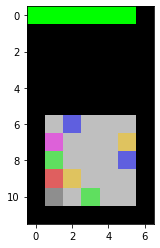

{'health': 2.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 6, 'key_00_y': 5, 'key_01_x': 10, 'key_01_y': 5, 'chest_00_x': 9, 'chest_00_y': 3, 'chest_01_x': 10, 'chest_01_y': 2, 'food_00_x': 9, 'food_00_y': 4, 'food_01_x': 10, 'food_01_y': 4, 'button_x': 7, 'button_y': 3, 'player_x': 7, 'player_y': 1, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 7, 'lamp_off_y': 4}


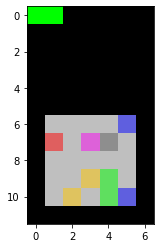

{'health': 13.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 7, 'key_00_y': 5, 'key_01_x': 10, 'key_01_y': 3, 'chest_00_x': 7, 'chest_00_y': 1, 'chest_01_x': 10, 'chest_01_y': 2, 'food_00_x': 8, 'food_00_y': 2, 'food_01_x': -1, 'food_01_y': -1, 'button_x': 8, 'button_y': 4, 'player_x': 9, 'player_y': 1, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 10, 'lamp_off_y': 5}


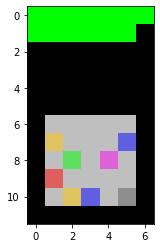

{'health': 4.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 6, 'key_00_y': 2, 'key_01_x': 7, 'key_01_y': 5, 'chest_00_x': 7, 'chest_00_y': 2, 'chest_01_x': 10, 'chest_01_y': 4, 'food_00_x': 7, 'food_00_y': 4, 'food_01_x': 8, 'food_01_y': 4, 'button_x': 8, 'button_y': 5, 'player_x': 9, 'player_y': 5, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 9, 'lamp_off_y': 1}


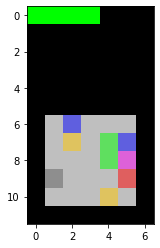

{'health': 4.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 6, 'key_00_y': 4, 'key_01_x': 10, 'key_01_y': 4, 'chest_00_x': 9, 'chest_00_y': 3, 'chest_01_x': 10, 'chest_01_y': 1, 'food_00_x': 7, 'food_00_y': 3, 'food_01_x': 10, 'food_01_y': 3, 'button_x': 7, 'button_y': 2, 'player_x': 7, 'player_y': 4, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 9, 'lamp_off_y': 1}


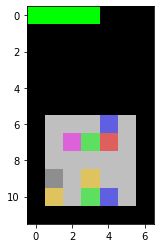

{'health': 4.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 8, 'key_00_y': 2, 'key_01_x': 10, 'key_01_y': 3, 'chest_00_x': 9, 'chest_00_y': 2, 'chest_01_x': 10, 'chest_01_y': 4, 'food_00_x': 6, 'food_00_y': 3, 'food_01_x': 9, 'food_01_y': 3, 'button_x': 10, 'button_y': 2, 'player_x': 8, 'player_y': 5, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 7, 'lamp_off_y': 2}


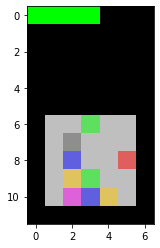

{'health': 2.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 6, 'key_00_y': 1, 'key_01_x': 8, 'key_01_y': 5, 'chest_00_x': 7, 'chest_00_y': 3, 'chest_01_x': 10, 'chest_01_y': 4, 'food_00_x': 8, 'food_00_y': 3, 'food_01_x': 9, 'food_01_y': 3, 'button_x': 9, 'button_y': 2, 'player_x': 8, 'player_y': 1, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 10, 'lamp_off_y': 5}


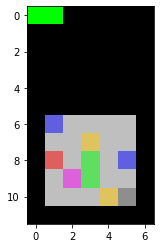

{'health': 3.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 6, 'key_00_y': 4, 'key_01_x': 9, 'key_01_y': 4, 'chest_00_x': 6, 'chest_00_y': 3, 'chest_01_x': 9, 'chest_01_y': 2, 'food_00_x': 6, 'food_00_y': 1, 'food_01_x': 8, 'food_01_y': 1, 'button_x': 9, 'button_y': 3, 'player_x': 7, 'player_y': 4, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 8, 'lamp_off_y': 5}


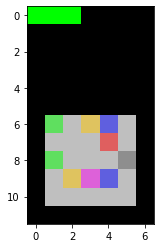

{'health': 4.0, 'keys': 1.0, 'lamp_status': 0, 'key_00_x': 9, 'key_00_y': 5, 'key_01_x': -1, 'key_01_y': -1, 'chest_00_x': 6, 'chest_00_y': 1, 'chest_01_x': 7, 'chest_01_y': 1, 'food_00_x': 6, 'food_00_y': 2, 'food_01_x': 8, 'food_01_y': 4, 'button_x': 6, 'button_y': 5, 'player_x': 9, 'player_y': 3, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 10, 'lamp_off_y': 5}


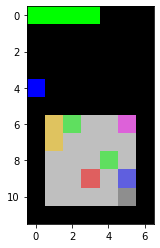

{'health': 8.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 9, 'key_00_y': 1, 'key_01_x': 10, 'key_01_y': 4, 'chest_00_x': 6, 'chest_00_y': 3, 'chest_01_x': 10, 'chest_01_y': 1, 'food_00_x': 7, 'food_00_y': 2, 'food_01_x': 9, 'food_01_y': 5, 'button_x': 7, 'button_y': 5, 'player_x': 7, 'player_y': 3, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 9, 'lamp_off_y': 3}


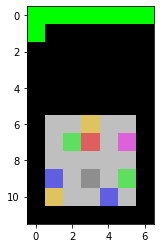

In [474]:
for i in range(10):
    idx = np.random.choice(len(X))
#     idx = i
    print(Fdict[idx])
    plt.imshow(X_rgb[idx])
    plt.show()

# Embedder model

In [475]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(h * w * c, )),
    tf.keras.layers.Dense(512, activation='sigmoid'),
    tf.keras.layers.Dense(F.shape[1], activation=None)
])

In [476]:
model.compile(tf.optimizers.Adam(lr=1e-4), 'mse', metrics=['mae'])

In [477]:
import sklearn

In [478]:
Xn_scaler = sklearn.preprocessing.StandardScaler()
Fn_scaler = sklearn.preprocessing.StandardScaler()

In [479]:
Xn = Xn_scaler.fit_transform(X.reshape(X.shape[0], -1))
Fn = Fn_scaler.fit_transform(F)

In [ ]:
history = model.fit(Xn, Fn, epochs=50000, validation_split=0.1, batch_size=512, verbose=0)#, callbacks=[TQDMNotebookCallback(leave_inner=False)])

/home/serge/miniconda3/envs/causal/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
plt.plot(history.history['loss'])
plt.yscale('log')

In [ ]:
plt.plot(history.history['mae'])
plt.yscale('log')

In [ ]:
np.std(F, axis=0)

In [ ]:
np.mean(F, axis=0)

In [ ]:
model

In [ ]:
model.evaluate(Xn, Fn)

In [ ]:
assert len(X_rgb) == len(Xn)

In [ ]:
idx = np.random.choice(len(Xn))
img = X_rgb[idx]
Xn_idx = Xn[idx:idx+1]
f_pred = model.predict(Xn_idx)[0]
f_pred_scaled = f_pred * (Fn_scaler.var_ ** 0.5) + Fn_scaler.mean_
f_pred_dct = arr_to_dict(f_pred_scaled, Fkeys)
f_true_dct = Fdict[idx]

# print(f_pred_dct, f_true_dct)
plt.imshow(img)
df = pd.DataFrame({'pred': f_pred_dct, 'true': f_true_dct})
df['error'] = np.abs(df.pred - df.true)
df

# Generator model

In [ ]:
Xmasked = np.copy(X)
Xmasked[:, :, :, 4:] = 0
X_rgb = obss_to_rgb(Xmasked, env.engine)

In [ ]:
Fdict = [obs_features_handcoded(x, env) for x in X]
F = np.array([dict_to_arr(f) for f in Fdict])

In [ ]:
plt.imshow(X_rgb[10])

In [ ]:
import sklearn
Xn_scaler = sklearn.preprocessing.StandardScaler()
Fn_scaler = sklearn.preprocessing.StandardScaler()

In [ ]:
# normalization
Xn = Xn_scaler.fit_transform(Xmasked.reshape(X.shape[0], -1))
Fn = Fn_scaler.fit_transform(F)
# Xn = X.reshape(X.shape[0], -1)
# Fn = F

In [ ]:
env.engine.OBJECTS

In [ ]:
sorted(Fkeys).index('health')

In [ ]:
plt.hist(F[:, 10])

In [ ]:
plt.hist(Fn[:, 10])

In [ ]:
#np.max(np.abs(Fnew - F))

In [526]:
generator = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(F.shape[1], )),
#     tf.keras.layers.Dense(F.shape[1], activation='relu'),
#     tf.keras.layers.Dense(1, activation='relu'), # +4096, 4096
#     tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense((h * w * 3), activation='relu'),
    tf.keras.layers.Reshape((h, w, 3))
])

In [527]:
Xn.shape, Fn.shape

((91664, 924), (91664, 23))

In [528]:
@tf.function
def sse(y_true, y_pred):
    
    l = tf.abs(y_true - y_pred) ** 4
    l = tf.reduce_mean(l, axis=0)
    l = tf.reduce_sum(l)

    return l

In [529]:
#generator.compile(tf.optimizers.Adam(lr=1e-4), 'mse', metrics=['mae'])
generator.compile(tf.optimizers.Adam(lr=1e-5), 'mse', metrics=['mae'])

In [538]:
# validation_split=0.1,
# history = generator.fit(Fn, Xn, epochs=5000,  batch_size=512, verbose=0)#, callbacks=[TQDMNotebookCallback(leave_inner=False)])
history = generator.fit(F, X_rgb, epochs=5000,  batch_size=512, verbose=0)#, callbacks=[TQDMNotebookCallback(leave_inner=False)])

<IPython.core.display.Javascript object>

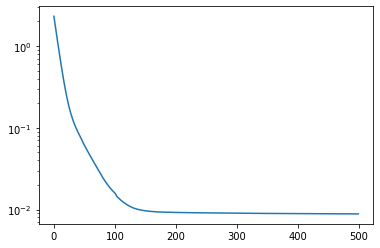

In [531]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.yscale('log')

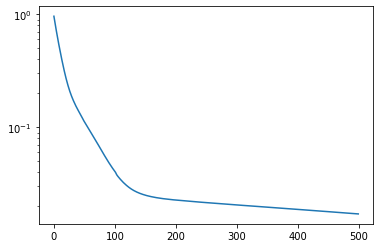

In [532]:
plt.plot(history.history['mae'])
# plt.plot(history.history['val_mae'])
plt.yscale('log')

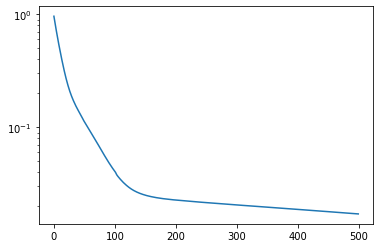

In [533]:
plt.plot(history.history['mae'])
# plt.plot(history.history['val_mae'])
plt.yscale('log')

In [534]:
generator.evaluate(F, X_rgb)

[0.008836407413136238, 0.017133368]

79648 {'health': 8.0, 'keys': 0.0, 'lamp_status': 0, 'key_00_x': 6, 'key_00_y': 1, 'key_01_x': 10, 'key_01_y': 5, 'chest_00_x': 6, 'chest_00_y': 2, 'chest_01_x': 7, 'chest_01_y': 1, 'food_00_x': -1, 'food_00_y': -1, 'food_01_x': -1, 'food_01_y': -1, 'button_x': 7, 'button_y': 5, 'player_x': 8, 'player_y': 2, 'lamp_on_x': -1, 'lamp_on_y': -1, 'lamp_off_x': 8, 'lamp_off_y': 3}


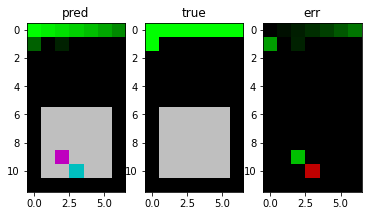

In [539]:
idx = np.random.choice(len(Xn))


img_true = X_rgb[idx]
Fn_idx = F[idx:idx+1]#Fn[idx:idx+1]
img_pred_flat = generator.predict(Fn_idx)
img_pred_flat_rescaled = img_pred_flat
# img_pred_flat_rescaled = (img_pred_flat * (Xn_scaler.var_ ** 0.5) + Xn_scaler.mean_)
img_pred = img_pred_flat_rescaled#.reshape((1, h, w, c))
# img_pred_rgb = obss_to_rgb(img_pred, env.engine)[0]
img_pred_rgb = img_pred[0]
Fdict_idx = Fdict[idx]

print(idx, Fdict_idx)

img_pred_rgb[img_pred_rgb > 1] = 1
img_pred_rgb[img_pred_rgb < 0] = 0

plt.subplot(1, 3, 1)
plt.title('pred')
plt.imshow(img_pred_rgb)
plt.subplot(1, 3, 2)
plt.title('true')
plt.imshow(img_true)
plt.subplot(1, 3, 3)
plt.title('err')
plt.imshow(np.abs(img_pred_rgb - img_true))
plt.show()

In [536]:
np.mean(np.abs(img_pred - X[idx]))

ValueError: operands could not be broadcast together with shapes (1,12,7,3) (12,7,11) 

In [ ]:
F[idx]

In [ ]:
np.sum(np.abs(img_pred_flat - Xn[idx]))

In [ ]:
np.sum(np.abs((img_pred - X[idx]).flatten()))

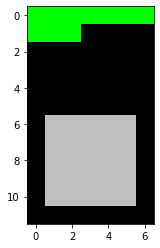

In [520]:
plt.imshow(X_rgb[idx])